In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from data_loader import CustomSignalData, CustomSignalData1
from torch.autograd import Variable
from encoder import Encoder as E
from helpers import set_cmd_cb, rms_formuula, get_data, get_all_data, get_shift_data, get_operators, plot_cfs_mat, roll_data

features = ['RMS', 'MAV', 'SSC', 'ZC', 'WL']

DEVICE = torch.device("cpu")

def getFeatureMatrix(rawDataMatrix, window_size, overlap_factor):
    nChannels, nSamples = rawDataMatrix.shape
    stride = int(window_size * overlap_factor)
    num_stride = int(np.floor(nSamples/(window_size-stride)))
    featMatrix = np.zeros((nChannels*len(features),num_stride))
    # Define a dictionary that maps feature names to functions that calculate those features
    feature_functions = {
        'RMS': lambda x: np.sqrt(np.mean(x ** 2, axis=1)),
        'MAV': lambda x: np.mean(np.abs(x), axis=1),
        'SSC': lambda x: np.mean(((x[:, 1:-1] - x[:, :-2]) * (x[:, 2:] - x[:, 1:-1])) < 0, axis=1).reshape(-1, 1),
        'ZC': lambda x: np.mean((x[:, :-1] * x[:, 1:] < 0) & (np.abs(x[:, :-1] - x[:, 1:]) > 0), axis=1).reshape(-1, 1),
        'WL': lambda x: np.mean(np.abs(x[:, :-1] - x[:, 1:]), axis=1)
    }
    # Loop over the features 
    featIndex = 0
    for feature in features:
        if feature in feature_functions:
            featFunc = feature_functions[feature]
            for i in range(num_stride):
                wdwStrtIdx = i*(window_size-stride)
                if i == num_stride:
                    sigWin = rawDataMatrix[:, wdwStrtIdx:nSamples] 
                else:
                    sigWin = rawDataMatrix[:, wdwStrtIdx:(wdwStrtIdx+window_size-1)] 
                
                featValues = featFunc(sigWin)
                featValues = featValues.flatten() # Flatten featValues before assigning it to featMatrix
                featMatrix[featIndex:featIndex + nChannels, i] = featValues     
            featIndex += nChannels
    return featMatrix

# def getFeatureMatrix(rawDataMatrix, windowLength, windowOverlap):
#     rms = lambda sig: np.sqrt(np.mean(sig**2))
#     nChannels,nSamples = rawDataMatrix.shape    
#     I = int(np.floor(nSamples/(windowLength-windowOverlap)))
#     featMatrix = np.zeros([nChannels, I])
#     for channel in range(nChannels):
#         for i in range (I):
#             wdwStrtIdx=i*(windowLength-windowOverlap)
#             sigWin = rawDataMatrix[channel][wdwStrtIdx:(wdwStrtIdx+windowLength-1)] 
#             featMatrix[channel, i] = rms(sigWin)
#     featMatrixData = np.array(featMatrix)
#     return featMatrixData

class FFNN(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(FFNN, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(inputSize, 9, bias=False),
            torch.nn.Sigmoid()
        )
        self.classifer = torch.nn.Sequential(
            torch.nn.Linear(9, outputSize, bias=False),
            # torch.nn.Softmax(dim=1)
        )

    def forward(self, x, encoder=None):
        if not encoder:
            encoder = self.encoder
        z = encoder(x)
        class_z = self.classifer(z)

        return class_z

class Operator(nn.Module):
    def __init__(self, in_features, n_rotations):
        super(Operator, self).__init__()
        """
        Args:
          in_features (int): Number of input features which should be equal to xsize.
          out_features (out): Number of output features which should be equal to ysize.
        """
        self.in_features = in_features
        self.core = torch.nn.Parameter(torch.zeros(3*self.in_features**2)- 0*torch.diag(torch.rand(3*self.in_features**2)/10))
        self.core.requires_grad = True
        self.n_rotations = n_rotations
        
    def rotate_batch(self, x, d, out_features):
      rotated = torch.empty(x.shape[0], 3*out_features*out_features, device=DEVICE)
      phies = [torch.linalg.matrix_power(self.core,i).to(DEVICE) for i in range (0,self.n_rotations+0)]
      for i in range (x.shape[0]):
        rotated[i] = phies[(d[i]+0)%4].matmul(x[i]) 
      return rotated

    def forward(self, x, d):
        """
        Args:
          x of shape (batch_size, 3, xsize, xsize): Inputs.
        
        Returns:
          y of shape (batch_size, 3*xsize^2): Outputs.
        """
        z = self.rotate_batch(x, d, self.in_features)
        return z
def get_tensor(arr):
    return torch.tensor(arr, device=DEVICE,dtype=torch.float )

def rotate_batch(x, d, out_features):
    M = torch.diag(torch.ones(8)).roll(-1,1)
    used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)]
    rotated = torch.empty(x.shape, device=DEVICE)
    for i in range (x.shape[0]):
        rotated[i] = used_bases[d[i]].matmul(x[i]) 
    return rotated

def clf_acc(model, loader, masks = None, encoder = None):
    model.eval()
    correct = 0
    iter = 0
    with torch.no_grad():
        for inputs, labels,_,_ in loader:
            inputs = inputs.to(DEVICE)
            if masks is not None:
                inputs = inputs * masks[:inputs.size()[0]]
            labels = labels.to(DEVICE)
            labels = labels.flatten()
            if encoder:
                pred = model(inputs, encoder)
            else:
                pred = model(inputs)
            correct += (1-torch.abs(torch.sign(torch.argmax(pred,dim = 1)- labels))).mean().item()
            iter += 1
    return correct/iter

def compute_accuracy(a, b, loader):
    a.eval()
    b.eval()
    
    correct = 0
    iter = 0
    
    with torch.no_grad():
        for inputs1, inputs2, shift1, shift2, labels, _ in loader:
            inputs1 = inputs1.to(DEVICE)
            inputs2 = inputs2.to(DEVICE)
            shift1 = -shift1.int().flatten().to(DEVICE)
            shift2 = -shift2.int().flatten().to(DEVICE)
            labels = labels.flatten().to(DEVICE)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            y1 = a(inputs1)
            y_tr_est1 = rotate_batch(y1,shift1,6)
            y_tr1 = b(y_tr_est1)

            y2 = a(inputs2)
            y_tr_est2 = rotate_batch(y2,shift1,6)
            y_tr2 = b(y_tr_est2)

            correct += (1-torch.abs(torch.sign(torch.argmax(y_tr1,dim = 1)- labels))).mean().item() + \
                    (1-torch.abs(torch.sign(torch.argmax(y_tr2,dim = 1)- labels))).mean().item()
            iter += 1
    return correct * 0.5 / iter

In [16]:
import os
import pandas as pd
import numpy as np

subject = '26'

Fs = 1000
windowLength = int(np.floor(0.1 * Fs))  # 100ms
windowOverlap = 0.5  # 50% overlap

# Initialize empty lists to store data
X_train = [[np.zeros([0, 8 * 5]) for _ in range(9)] for _ in range(9)]  # Adjusting to accommodate 5 features
y_train = [[np.zeros([0]) for _ in range(9)] for _ in range(9)]
X_test = [[np.zeros([0, 8 * 5]) for _ in range(9)] for _ in range(9)]
y_test = [[np.zeros([0]) for _ in range(9)] for _ in range(9)]

for shift in range(0, 9):
    for files in sorted(os.listdir(f'Subject_{subject}/Shift_{shift}/')):
        _, class_, _, rep_ = files.split('_')
        
        df = pd.read_csv(f'Subject_{subject}/Shift_{shift}/{files}', skiprows=0, sep=' ', header=None)
        data_arr = np.stack([np.array(df.T[i::8]).T.flatten().astype('float32') for i in range(8)])
        data_arr -= 121
        data_arr /= 255.0
        feaData = getFeatureMatrix(data_arr, windowLength, windowOverlap)
        
        # Sum across each feature separately
        num_features = 5  # Number of features
        feature_sum = np.zeros((num_features, feaData.shape[1]))

        for f in range(num_features):
            feature_sum[f] = feaData[f*8:(f+1)*8, :].sum(axis=0)
        
        if not class_.startswith('9'):
            baseline = 2 * feature_sum.sum(axis=0)[-50:].mean()
            start_ = np.argmax(feature_sum.sum(axis=0) > baseline)
            end_ = len(feature_sum.sum(axis=0)) - np.argmax(feature_sum.sum(axis=0)[::-1] > baseline) - 1
            feaData = feaData.T[start_:end_]
        else:
            feaData = feaData.T
        
        for shift2 in range(9):
            if shift2 != shift:
                X_test[shift2][shift] = np.concatenate([X_test[shift2][shift], feaData])
                y_test[shift2][shift] = np.concatenate([y_test[shift2][shift], np.ones(feaData.shape[0]) * (int(class_) - 1)])


Logistc Regression

In [53]:
accuracies_LosReg_list_s2 = [[0 for _ in range(9)] for _ in range(9)]
for shift in range(9):
    logRegres  = load(f'LogisticRegression_shift_{shift}_s2_features_full.joblib')
    for shift2 in range(9):
        if shift != shift2:
            accuracy = logRegres.score(X_test[shift][shift2],y_test[shift][shift2])
            accuracies_LosReg_list_s2[shift][shift2]= accuracy

for element in accuracies_LosReg_list_s2:
    print(element)

[0, 0.42400482509047044, 0.26889757091897404, 0.2606219886114761, 0.25864884929472903, 0.2315681685196021, 0.2472163707493229, 0.3186435613982671, 0.5322525008623663]
[0.40929722961339804, 0, 0.2884321386104977, 0.19302087896043219, 0.18099480326651818, 0.25307197191339964, 0.2569966897381884, 0.32133253659994027, 0.26854087616419453]
[0.3302551259978087, 0.2629674306393245, 0, 0.3480800116805373, 0.2602821083890126, 0.17627267407840844, 0.2684321396328619, 0.21646250373468778, 0.28406347016212485]
[0.23462200657379872, 0.25557901085645357, 0.2578562935281128, 0, 0.2786933927245731, 0.19075482738443533, 0.1331628046945531, 0.25171795637884675, 0.21386685063815108]
[0.21098763499765222, 0.16797346200241253, 0.10361814166808221, 0.21711198715140897, 0, 0.26667641895845523, 0.10999097201324105, 0.11159247086943531, 0.12073128665056916]
[0.17858819846611362, 0.25392038600723765, 0.2497027348394768, 0.2483574244415243, 0.27602078693392723, 0, 0.28468251579897685, 0.25873916940543773, 0.1986

In [54]:
accuracies_LosReg_list_app1 = [0.8914261858746128, 0.9433724159618349, 0.9172854948605976, 0.9531751383647369, 0.8366960846221824, 0.8856894298314085, 0.9221498816337806, 0.9713560837002988, 0.977245465907905]

In [55]:
for shift in range(9):
    accuracies_LosReg_list_s2[shift][shift] = accuracies_LosReg_list_app1[shift]

for element in accuracies_LosReg_list_s2:
    print(element)

[0.8914261858746128, 0.42400482509047044, 0.26889757091897404, 0.2606219886114761, 0.25864884929472903, 0.2315681685196021, 0.2472163707493229, 0.3186435613982671, 0.5322525008623663]
[0.40929722961339804, 0.9433724159618349, 0.2884321386104977, 0.19302087896043219, 0.18099480326651818, 0.25307197191339964, 0.2569966897381884, 0.32133253659994027, 0.26854087616419453]
[0.3302551259978087, 0.2629674306393245, 0.9172854948605976, 0.3480800116805373, 0.2602821083890126, 0.17627267407840844, 0.2684321396328619, 0.21646250373468778, 0.28406347016212485]
[0.23462200657379872, 0.25557901085645357, 0.2578562935281128, 0.9531751383647369, 0.2786933927245731, 0.19075482738443533, 0.1331628046945531, 0.25171795637884675, 0.21386685063815108]
[0.21098763499765222, 0.16797346200241253, 0.10361814166808221, 0.21711198715140897, 0.8366960846221824, 0.26667641895845523, 0.10999097201324105, 0.11159247086943531, 0.12073128665056916]
[0.17858819846611362, 0.25392038600723765, 0.2497027348394768, 0.24835

In [56]:
accuracies_LosReg_list_s2 = accuracies_LosReg_list_s2[5:] + accuracies_LosReg_list_s2[:5]
for element in accuracies_LosReg_list_s2:
    print(element)

[0.17858819846611362, 0.25392038600723765, 0.2497027348394768, 0.2483574244415243, 0.27602078693392723, 0.8856894298314085, 0.28468251579897685, 0.25873916940543773, 0.1986892031735081]
[0.2560651119110972, 0.2646260554885404, 0.23288602004416512, 0.11286319170681851, 0.18841870824053453, 0.1759801053247513, 0.9221498816337806, 0.35315207648640573, 0.25974473956536737]
[0.2508999843480983, 0.17475874547647768, 0.2417190419568541, 0.2512775587677033, 0.24810690423162585, 0.23946752486834405, 0.29491423412578993, 0.9713560837002988, 0.33787512935495]
[0.5820942244482704, 0.3707780458383595, 0.27382367929335827, 0.2114177252153599, 0.25196733481811434, 0.22586307782328846, 0.24736683719530544, 0.3512100388407529, 0.977245465907905]
[0.8914261858746128, 0.42400482509047044, 0.26889757091897404, 0.2606219886114761, 0.25864884929472903, 0.2315681685196021, 0.2472163707493229, 0.3186435613982671, 0.5322525008623663]
[0.40929722961339804, 0.9433724159618349, 0.2884321386104977, 0.1930208789604

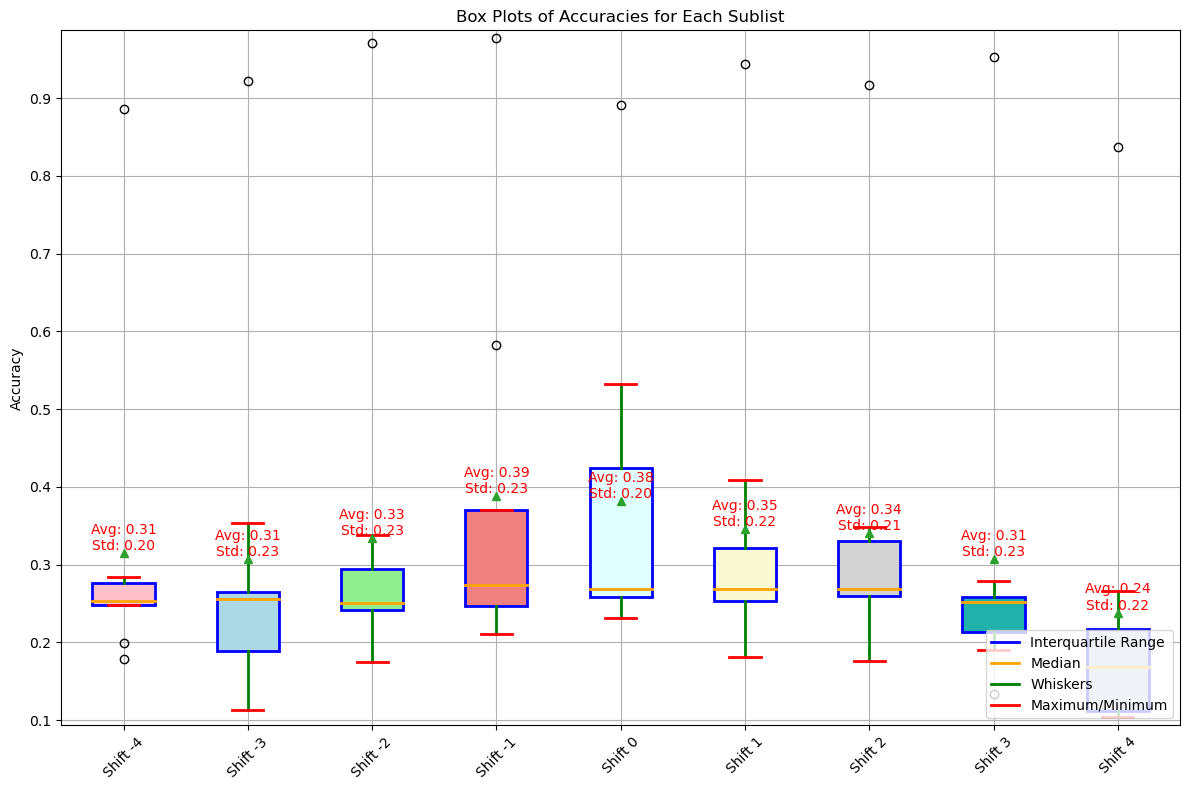

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Your list of lists (sample data for brevity)
accuracies_LosReg_list_s2 = [
    [0.17858819846611362, 0.25392038600723765, 0.2497027348394768, 0.2483574244415243, 0.27602078693392723, 0.8856894298314085, 0.28468251579897685, 0.25873916940543773, 0.1986892031735081],
    [0.2560651119110972, 0.2646260554885404, 0.23288602004416512, 0.11286319170681851, 0.18841870824053453, 0.1759801053247513, 0.9221498816337806, 0.35315207648640573, 0.25974473956536737],
    [0.2508999843480983, 0.17475874547647768, 0.2417190419568541, 0.2512775587677033, 0.24810690423162585, 0.23946752486834405, 0.29491423412578993, 0.9713560837002988, 0.33787512935495],
    [0.5820942244482704, 0.3707780458383595, 0.27382367929335827, 0.2114177252153599, 0.25196733481811434, 0.22586307782328846, 0.24736683719530544, 0.3512100388407529, 0.977245465907905],
    [0.8914261858746128, 0.42400482509047044, 0.26889757091897404, 0.2606219886114761, 0.25864884929472903, 0.2315681685196021, 0.2472163707493229, 0.3186435613982671, 0.5322525008623663],
    [0.40929722961339804, 0.9433724159618349, 0.2884321386104977, 0.19302087896043219, 0.18099480326651818, 0.25307197191339964, 0.2569966897381884, 0.32133253659994027, 0.26854087616419453],
    [0.3302551259978087, 0.2629674306393245, 0.9172854948605976, 0.3480800116805373, 0.2602821083890126, 0.17627267407840844, 0.2684321396328619, 0.21646250373468778, 0.28406347016212485],
    [0.23462200657379872, 0.25557901085645357, 0.2578562935281128, 0.9531751383647369, 0.2786933927245731, 0.19075482738443533, 0.1331628046945531, 0.25171795637884675, 0.21386685063815108],
    [0.21098763499765222, 0.16797346200241253, 0.10361814166808221, 0.21711198715140897, 0.8366960846221824, 0.26667641895845523, 0.10999097201324105, 0.11159247086943531, 0.12073128665056916]
]

# Calculate average and standard deviation
averages = [np.mean(lst) for lst in accuracies_LosReg_list_s2]
std_devs = [np.std(lst) for lst in accuracies_LosReg_list_s2]

# Plot boxplot with customized colors and statistics
plt.figure(figsize=(12, 8))
colors = ['pink', 'lightblue', 'lightgreen', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightseagreen', 'lightsteelblue']
boxprops = dict(color="blue", linewidth=2)
medianprops = dict(color="orange", linewidth=2)
whiskerprops = dict(color="green", linewidth=2)
capprops = dict(color="red", linewidth=2)
box = plt.boxplot(accuracies_LosReg_list_s2, showmeans=True, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

shift_labels = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
plt.xticks(range(1, len(accuracies_LosReg_list_s2) + 1), [f'Shift {shift_labels[i]}' for i in range(len(accuracies_LosReg_list_s2))], rotation=45)
plt.ylabel('Accuracy')
plt.title('Box Plots of Accuracies for Each Sublist')

# Adjust y-axis limits for better visualization
min_val = min(min(sublist) for sublist in accuracies_LosReg_list_s2)
max_val = max(max(sublist) for sublist in accuracies_LosReg_list_s2)
plt.ylim(min_val - 0.01, max_val + 0.01)

plt.grid(True)

# Add average and standard deviation text
for i in range(len(accuracies_LosReg_list_s2)):
    plt.text(i + 1, averages[i], f'Avg: {averages[i]:.2f}\nStd: {std_devs[i]:.2f}', horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='red')

# Add legend explaining box components
legend_elements = [
    plt.Line2D([0], [0], color='blue', lw=2, label='Interquartile Range'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Median'),
    plt.Line2D([0], [0], color='green', lw=2, label='Whiskers'),
    plt.Line2D([0], [0], color='red', lw=2, label='Maximum/Minimum')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()


Feed Forward Neural Network

In [58]:
accuracies_FFNN_list_s2 = [[0 for _ in range(9)] for _ in range(9)]
for shift in range(9):
    modelWOoperator = FFNN(40,9)
    modelWOoperator.load_state_dict(torch.load(f"modelwoOperator_fshift_{shift}_s2.pt")) # loaded from the file: parameters learned during training.
    modelWOoperator.eval()

    for shift2 in range(9):
        if shift != shift2:
            test_shift_dataset = CustomSignalData(get_tensor(X_test[shift][shift2]), get_tensor(y_test[shift][shift2]))
            testshiftloader = torch.utils.data.DataLoader(test_shift_dataset, batch_size=24, shuffle=True)
            accuracies_FFNN_list_s2[shift][shift2] = clf_acc(modelWOoperator, testshiftloader, encoder = None)

for element in accuracies_FFNN_list_s2:
    print(element)

[0, 0.7299939826507431, 0.45124371137803165, 0.23125485578304403, 0.2289442465478203, 0.1996783619648532, 0.25760310548038257, 0.16108667347112865, 0.5359356569603455]
[0.7993133563673898, 0, 0.43261227435697386, 0.2490287483832636, 0.33573546888989486, 0.32947368444057934, 0.16595558514179737, 0.29370315967121, 0.3937918152506194]
[0.3676342073172219, 0.6526774971708924, 0, 0.35067016316147953, 0.3571767503150417, 0.3804678364803917, 0.5084235881209804, 0.3900429022675347, 0.2893299874503258]
[0.3541822710845354, 0.38237063995552406, 0.6638840490240392, 0, 0.4578884955084621, 0.34649122848845365, 0.2967126133317121, 0.3632833705046698, 0.4700905166504797]
[0.4086142330245579, 0.39590854377953155, 0.37446767473366205, 0.5053904443145631, 0, 0.32181286543869136, 0.20849742811670802, 0.21497230253125604, 0.30049685159436434]
[0.16803995028752067, 0.2636883265947392, 0.326437280854074, 0.336052836863311, 0.39890272978998165, 0, 0.29323925096743375, 0.15070055419826164, 0.20107733124235938

In [59]:
accuracies_FFNN_list_app1 = [0.9338661481356798, 0.955006643089654, 0.9407109307109133, 0.9584015452643753, 0.8529041386237134, 0.9263467673949144, 0.931461577329992, 0.9798030915418785, 0.9811868358161545]

In [60]:
for shift in range(9):
    accuracies_FFNN_list_s2[shift][shift] = accuracies_FFNN_list_app1[shift]

for element in accuracies_FFNN_list_s2:
    print(element)

[0.9338661481356798, 0.7299939826507431, 0.45124371137803165, 0.23125485578304403, 0.2289442465478203, 0.1996783619648532, 0.25760310548038257, 0.16108667347112865, 0.5359356569603455]
[0.7993133563673898, 0.955006643089654, 0.43261227435697386, 0.2490287483832636, 0.33573546888989486, 0.32947368444057934, 0.16595558514179737, 0.29370315967121, 0.3937918152506194]
[0.3676342073172219, 0.6526774971708924, 0.9407109307109133, 0.35067016316147953, 0.3571767503150417, 0.3804678364803917, 0.5084235881209804, 0.3900429022675347, 0.2893299874503258]
[0.3541822710845354, 0.38237063995552406, 0.6638840490240392, 0.9584015452643753, 0.4578884955084621, 0.34649122848845365, 0.2967126133317121, 0.3632833705046698, 0.4700905166504797]
[0.4086142330245579, 0.39590854377953155, 0.37446767473366205, 0.5053904443145631, 0.8529041386237134, 0.32181286543869136, 0.20849742811670802, 0.21497230253125604, 0.30049685159436434]
[0.16803995028752067, 0.2636883265947392, 0.326437280854074, 0.336052836863311, 0

In [61]:
accuracies_FFNN_list_s2 = accuracies_FFNN_list_s2[5:] + accuracies_FFNN_list_s2[:5]
for element in accuracies_FFNN_list_s2:
    print(element)

[0.16803995028752067, 0.2636883265947392, 0.326437280854074, 0.336052836863311, 0.39890272978998165, 0.9263467673949144, 0.29323925096743375, 0.15070055419826164, 0.20107733124235938]
[0.22393882567628046, 0.26684717145422304, 0.2548151367714977, 0.1755536132186026, 0.27642348726873295, 0.3052631568490413, 0.931461577329992, 0.33808515282301066, 0.18206414855893485]
[0.16916354560059554, 0.21013838655251457, 0.2717528068649817, 0.35227272701221746, 0.24608540900873543, 0.26628654842313965, 0.4388469545311876, 0.9798030915418785, 0.2627656431022016]
[0.4848626737067762, 0.3662755721204978, 0.3963898569345474, 0.2654914522504473, 0.1650652434955288, 0.3220760237229498, 0.39240783307741695, 0.5020229186742536, 0.9811868358161545]
[0.9338661481356798, 0.7299939826507431, 0.45124371137803165, 0.23125485578304403, 0.2289442465478203, 0.1996783619648532, 0.25760310548038257, 0.16108667347112865, 0.5359356569603455]
[0.7993133563673898, 0.955006643089654, 0.43261227435697386, 0.249028748383263

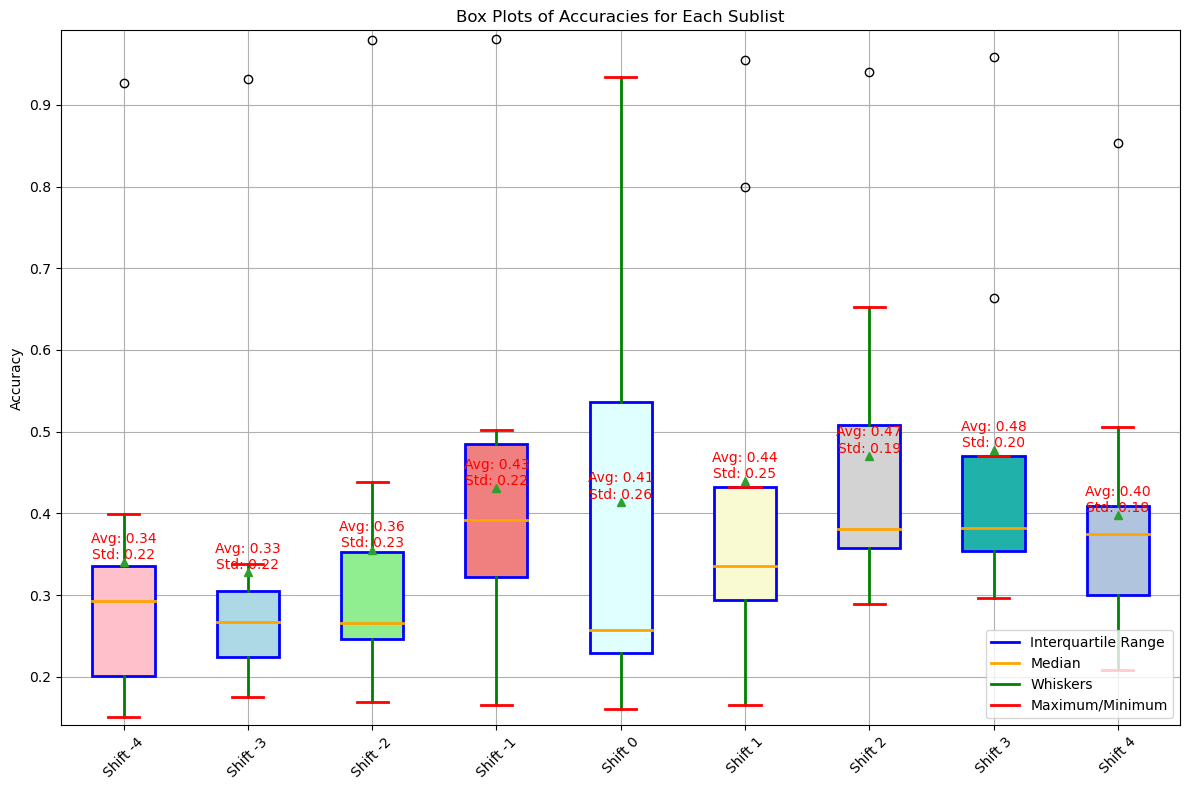

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate average and standard deviation
averages = [np.mean(lst) for lst in accuracies_FFNN_list_s2]
std_devs = [np.std(lst) for lst in accuracies_FFNN_list_s2]

# Plot boxplot with customized colors and statistics
plt.figure(figsize=(12, 8))
colors = ['pink', 'lightblue', 'lightgreen', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightseagreen', 'lightsteelblue']
boxprops = dict(color="blue", linewidth=2)
medianprops = dict(color="orange", linewidth=2)
whiskerprops = dict(color="green", linewidth=2)
capprops = dict(color="red", linewidth=2)
box = plt.boxplot(accuracies_FFNN_list_s2, showmeans=True, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

shift_labels = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
plt.xticks(range(1, len(accuracies_FFNN_list_s2) + 1), [f'Shift {shift_labels[i]}' for i in range(len(accuracies_FFNN_list_s2))], rotation=45)
plt.ylabel('Accuracy')
plt.title('Box Plots of Accuracies for Each Sublist')

# Adjust y-axis limits for better visualization
min_val = min(min(sublist) for sublist in accuracies_FFNN_list_s2)
max_val = max(max(sublist) for sublist in accuracies_FFNN_list_s2)
plt.ylim(min_val - 0.01, max_val + 0.01)

plt.grid(True)

# Add average and standard deviation text
for i in range(len(accuracies_FFNN_list_s2)):
    plt.text(i + 1, averages[i], f'Avg: {averages[i]:.2f}\nStd: {std_devs[i]:.2f}', horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='red')

# Add legend explaining box components
legend_elements = [
    plt.Line2D([0], [0], color='blue', lw=2, label='Interquartile Range'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Median'),
    plt.Line2D([0], [0], color='green', lw=2, label='Whiskers'),
    plt.Line2D([0], [0], color='red', lw=2, label='Maximum/Minimum')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()


Self-supervised Learning Model

In [63]:
DEVICE = torch.device("cpu") # operations is in CPU or GPU.
M = torch.diag(torch.ones(8)).roll(-1,1) # Create a diagnoise matrix then shift it to the right
used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)] #

N_points = 1000

accuracies_self_supervised_list_s2 = [[0 for _ in range(9)] for _ in range(9)]

for shift in range(9):
    classifier = FFNN(8,9) # This indicates that the neural network expects input data with 8 features and will produce output predictions across 9 classes.
    encoder = E(40,8)
    encoder.load_state_dict(torch.load(f"encoder_shift_{shift}_s2_full_features.pt")) # contains the learned parameters (weights and biases) of the encoder model
    recovered_points_= torch.load(f"reference_points_shift_{shift}_s2_full_features.pt") # These points represent reference points for inference or evaluation in the model
    classifier.load_state_dict(torch.load(f"classifier_shift_{shift}_s2_full_features.pt")) # contains the weights and biases learned during training.
    classifier.eval() # sets the model to evaluation mode.
    encoder.eval() # sets the model to evaluation mode.

    for shift2 in range(9):
        if shift != shift2:
            # Get the test data for the current shift and fold
            X_test_shift = X_test[shift][shift2]

            # Encode the test data using the encoder model
            y1 = encoder(get_tensor(X_test_shift))

            # Use the encoded data directly without rotation
            y_tr1 = classifier(y1).argmax(1)

            # Calculate accuracy and append to list
            accuracies_self_supervised_list_s2[shift][shift2] = (1 - torch.abs(torch.sign(y_tr1 - get_tensor(y_test[shift][shift2]).flatten()))).mean().item()
for accuracy in accuracies_self_supervised_list_s2:
    print(accuracy)

[0, 0.3048854172229767, 0.278070330619812, 0.1484888345003128, 0.16570155322551727, 0.15608543157577515, 0.16987662017345428, 0.26590976119041443, 0.2994135916233063]
[0.24463921785354614, 0, 0.17530150711536407, 0.1483428180217743, 0.14743874967098236, 0.20362785458564758, 0.17393921315670013, 0.1517777144908905, 0.28803035616874695]
[0.245578333735466, 0.252261757850647, 0, 0.2728865444660187, 0.23563474416732788, 0.14964891970157623, 0.164158895611763, 0.16492381691932678, 0.20179371535778046]
[0.16403192281723022, 0.1765681505203247, 0.18804144859313965, 0, 0.3202672600746155, 0.15169690549373627, 0.15212157368659973, 0.24439796805381775, 0.23266643285751343]
[0.2022225707769394, 0.15922798216342926, 0.2514013946056366, 0.20557746291160583, 0, 0.20596840977668762, 0.18131206929683685, 0.15013444423675537, 0.2885477840900421]
[0.1621537059545517, 0.2809107303619385, 0.20519790053367615, 0.25302964448928833, 0.24706755578517914, 0, 0.16746915876865387, 0.15013444423675537, 0.17971713

In [64]:
accuracies_self_supervised_list_app1 = [0.9298203587532043, 0.9481531381607056, 0.9334482749303182, 0.9490225315093994, 0.8222913940747579, 0.9200274348258972, 0.9195766448974609, 0.974602460861206, 0.9800923665364584]

In [65]:
for shift in range(9):
    accuracies_self_supervised_list_s2[shift][shift] = accuracies_self_supervised_list_app1[shift]

for element in accuracies_self_supervised_list_s2:
    print(element)

[0.9298203587532043, 0.3048854172229767, 0.278070330619812, 0.1484888345003128, 0.16570155322551727, 0.15608543157577515, 0.16987662017345428, 0.26590976119041443, 0.2994135916233063]
[0.24463921785354614, 0.9481531381607056, 0.17530150711536407, 0.1483428180217743, 0.14743874967098236, 0.20362785458564758, 0.17393921315670013, 0.1517777144908905, 0.28803035616874695]
[0.245578333735466, 0.252261757850647, 0.9334482749303182, 0.2728865444660187, 0.23563474416732788, 0.14964891970157623, 0.164158895611763, 0.16492381691932678, 0.20179371535778046]
[0.16403192281723022, 0.1765681505203247, 0.18804144859313965, 0.9490225315093994, 0.3202672600746155, 0.15169690549373627, 0.15212157368659973, 0.24439796805381775, 0.23266643285751343]
[0.2022225707769394, 0.15922798216342926, 0.2514013946056366, 0.20557746291160583, 0.8222913940747579, 0.20596840977668762, 0.18131206929683685, 0.15013444423675537, 0.2885477840900421]
[0.1621537059545517, 0.2809107303619385, 0.20519790053367615, 0.2530296444

In [66]:
accuracies_self_supervised_list_s2 = accuracies_self_supervised_list_s2[5:] + accuracies_self_supervised_list_s2[:5]
for element in accuracies_self_supervised_list_s2:
    print(element)

[0.1621537059545517, 0.2809107303619385, 0.20519790053367615, 0.25302964448928833, 0.24706755578517914, 0.9200274348258972, 0.16746915876865387, 0.15013444423675537, 0.17971713840961456]
[0.2762560546398163, 0.2644752860069275, 0.24307796359062195, 0.03182946518063545, 0.1174461767077446, 0.2788180112838745, 0.9195766448974609, 0.2544069290161133, 0.2281821370124817]
[0.26889967918395996, 0.1869722604751587, 0.1822660118341446, 0.2511315643787384, 0.12843355536460876, 0.2384435385465622, 0.2777610719203949, 0.974602460861206, 0.28837528824806213]
[0.5105650424957275, 0.18923401832580566, 0.17428231239318848, 0.16659365594387054, 0.24513734877109528, 0.22952018678188324, 0.2551910877227783, 0.2854795455932617, 0.9800923665364584]
[0.9298203587532043, 0.3048854172229767, 0.278070330619812, 0.1484888345003128, 0.16570155322551727, 0.15608543157577515, 0.16987662017345428, 0.26590976119041443, 0.2994135916233063]
[0.24463921785354614, 0.9481531381607056, 0.17530150711536407, 0.148342818021

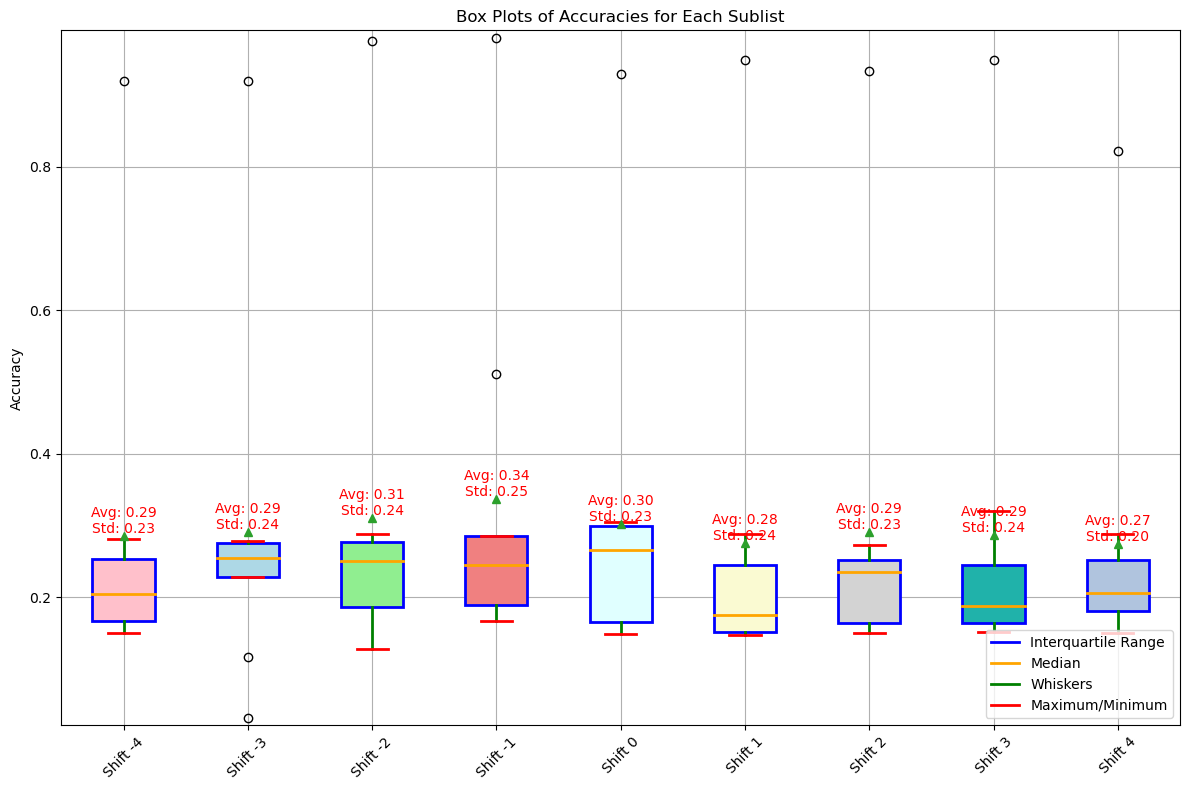

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate average and standard deviation
averages = [np.mean(lst) for lst in accuracies_self_supervised_list_s2]
std_devs = [np.std(lst) for lst in accuracies_self_supervised_list_s2]

# Plot boxplot with customized colors and statistics
plt.figure(figsize=(12, 8))
colors = ['pink', 'lightblue', 'lightgreen', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightseagreen', 'lightsteelblue']
boxprops = dict(color="blue", linewidth=2)
medianprops = dict(color="orange", linewidth=2)
whiskerprops = dict(color="green", linewidth=2)
capprops = dict(color="red", linewidth=2)
box = plt.boxplot(accuracies_self_supervised_list_s2, showmeans=True, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

shift_labels = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
plt.xticks(range(1, len(accuracies_self_supervised_list_s2) + 1), [f'Shift {shift_labels[i]}' for i in range(len(accuracies_self_supervised_list_s2))], rotation=45)
plt.ylabel('Accuracy')
plt.title('Box Plots of Accuracies for Each Sublist')

# Adjust y-axis limits for better visualization
min_val = min(min(sublist) for sublist in accuracies_self_supervised_list_s2)
max_val = max(max(sublist) for sublist in accuracies_self_supervised_list_s2)
plt.ylim(min_val - 0.01, max_val + 0.01)

plt.grid(True)

# Add average and standard deviation text
for i in range(len(accuracies_self_supervised_list_s2)):
    plt.text(i + 1, averages[i], f'Avg: {averages[i]:.2f}\nStd: {std_devs[i]:.2f}', horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='red')

# Add legend explaining box components
legend_elements = [
    plt.Line2D([0], [0], color='blue', lw=2, label='Interquartile Range'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Median'),
    plt.Line2D([0], [0], color='green', lw=2, label='Whiskers'),
    plt.Line2D([0], [0], color='red', lw=2, label='Maximum/Minimum')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()
